# Covid19 Epidemic Diffusion - Toy Model on Lombardia's Road Network
Let's simulate a SIR epidemic model, on Lombardia's [Road Network ("Rete Stradale")](https://www.dati.lombardia.it/widgets/nyxe-8s3y). By opening the zipped file you'll find a **shapefile**, I decided to convert it into a **.json** (by using [MapShaper](https://mapshaper.org)) because it's much more easy to play with it in *Geopandas* and *Pandas*

### Import Libraries

In [1]:
import pandas as pd 
import geopandas as gpd
from scipy.io import mmread
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import random

import EoN # Epidemics on Networks

# For dynamically updated plots  
%matplotlib notebook 


### A few utilities 

In [2]:
def linestring_to_points(line):
    return line.coords

def get_first_last_point(points):
    
    l = list(points)
    res = [l[0], l[-1]]
    
    return res 

def mergeDict(dict1, dict2):
    ''' Merge dictionaries and keep values of common keys in list'''
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items():
        if key in dict1 and key in dict2:
            dict3[key] = tuple([value , dict1[key]])
    return dict3


## Let's play with Geographic data 

In [3]:
DF_Lombardia = gpd.read_file("Rete_stradale_lombardia/Rete_stradale_line.json")
DF_Lombardia.head()

,TIPO_ARCO,DTIPO_ARCO,STATO,DSTATO,EID,TIPO_CTR,DTIPO_CTR,COD_ELE,NOME,PRO,CLASS,DCLASS,EXTRA_RL,DEXTRA_RL,geometry
0,1,Strada,1,In Esercizio,14000,304,Strada Comunale,NA_SO,STRADE COMUNALI PROVINCIA DI SONDRIO,SO,3,Altre strade,1,Interno confine regionale,"LINESTRING (565700.694 5119978.797, 565712.443..."
1,1,Strada,1,In Esercizio,14000,304,Strada Comunale,NA_SO,STRADE COMUNALI PROVINCIA DI SONDRIO,SO,3,Altre strade,1,Interno confine regionale,"LINESTRING (565878.691 5119303.310, 565882.441..."
2,1,Strada,1,In Esercizio,125,302,Strada Statale,SS36,DEL LAGO DI COMO E DELLO SPLUGA,SO,2,Strade secondarie,1,Interno confine regionale,"LINESTRING (534008.245 5119627.264, 534017.369..."
3,1,Strada,1,In Esercizio,14000,304,Strada Comunale,NA_SO,STRADE COMUNALI PROVINCIA DI SONDRIO,SO,3,Altre strade,1,Interno confine regionale,"LINESTRING (565878.691 5119303.310, 565888.816..."
4,1,Strada,1,In Esercizio,14000,304,Strada Comunale,NA_SO,STRADE COMUNALI PROVINCIA DI SONDRIO,SO,3,Altre strade,1,Interno confine regionale,"LINESTRING (565892.566 5119264.311, 565893.816..."


In [4]:
# Speed Limit per different road type
# Strada Comunale = 50 km/h --> w (weight) = 50 / 110 = 0.4545
# Strada Statale, Strada Provinciale = 90 km/h --> w = 90 /110 = 0.8181
# Autostrada, Tangenziale = 110 km/h --> w = 1 

for index, row in DF_Lombardia.iterrows():
    if row["DTIPO_CTR"] == "Strada Comunale":
        DF_Lombardia.loc[index, "weight_0"] = 50/110
    
    if (row["DTIPO_CTR"] == "Strada Statale") | (row["DTIPO_CTR"] == "Strada Provinciale"):
        DF_Lombardia.loc[index, "weight_0"] = 90/110
        
    if row["DTIPO_CTR"] == "Autostrada, Tangenziale":
        DF_Lombardia.loc[index, "weight_0"] = 1.0

In [5]:
DF_Lombardia["points"] = DF_Lombardia.apply(lambda l : linestring_to_points(l["geometry"]), axis = 1)
DF_Lombardia["first_point"] = DF_Lombardia.apply(lambda l: list(l["points"])[0], axis = 1)
DF_Lombardia["last_point"] = DF_Lombardia.apply(lambda l: list(l["points"])[-1], axis = 1)
DF_Lombardia["road_length"] = DF_Lombardia.apply(lambda l : l["geometry"].length, axis = 1)
DF_Lombardia["weight_0"] = DF_Lombardia.apply(lambda l : l["road_length"]/l["weight_0"], axis = 1, )
DF_Lombardia["weight_0"] = (DF_Lombardia.weight_0 - DF_Lombardia.weight_0.min())/(DF_Lombardia.weight_0.max()-DF_Lombardia.weight_0.min())
DF_Lombardia["weight_0"] = DF_Lombardia.apply(lambda l: 1 - l["weight_0"],axis = 1 )
DF_Lombardia["first_last_point"] = DF_Lombardia.apply(lambda l: (list(l["points"])[0], list(l["points"])[-1]),axis = 1)
DF_Lombardia = DF_Lombardia.drop_duplicates("first_last_point")
#DF_Lombardia["points"] = DF_Lombardia.apply(lambda l : list(l["points"]), axis = 1)

In [6]:
DF_Lombardia["x1"] = DF_Lombardia.apply(lambda l : l["first_point"][0], axis = 1) 
DF_Lombardia["y1"] = DF_Lombardia.apply(lambda l : l["first_point"][1], axis = 1) 
DF_Lombardia["x2"] = DF_Lombardia.apply(lambda l : l["last_point"][0], axis = 1) 
DF_Lombardia["y2"] = DF_Lombardia.apply(lambda l : l["last_point"][1], axis = 1) 

## Road Network Viz

### Road Graph (Data from Lombardia Region)

<IPython.core.display.Javascript object>


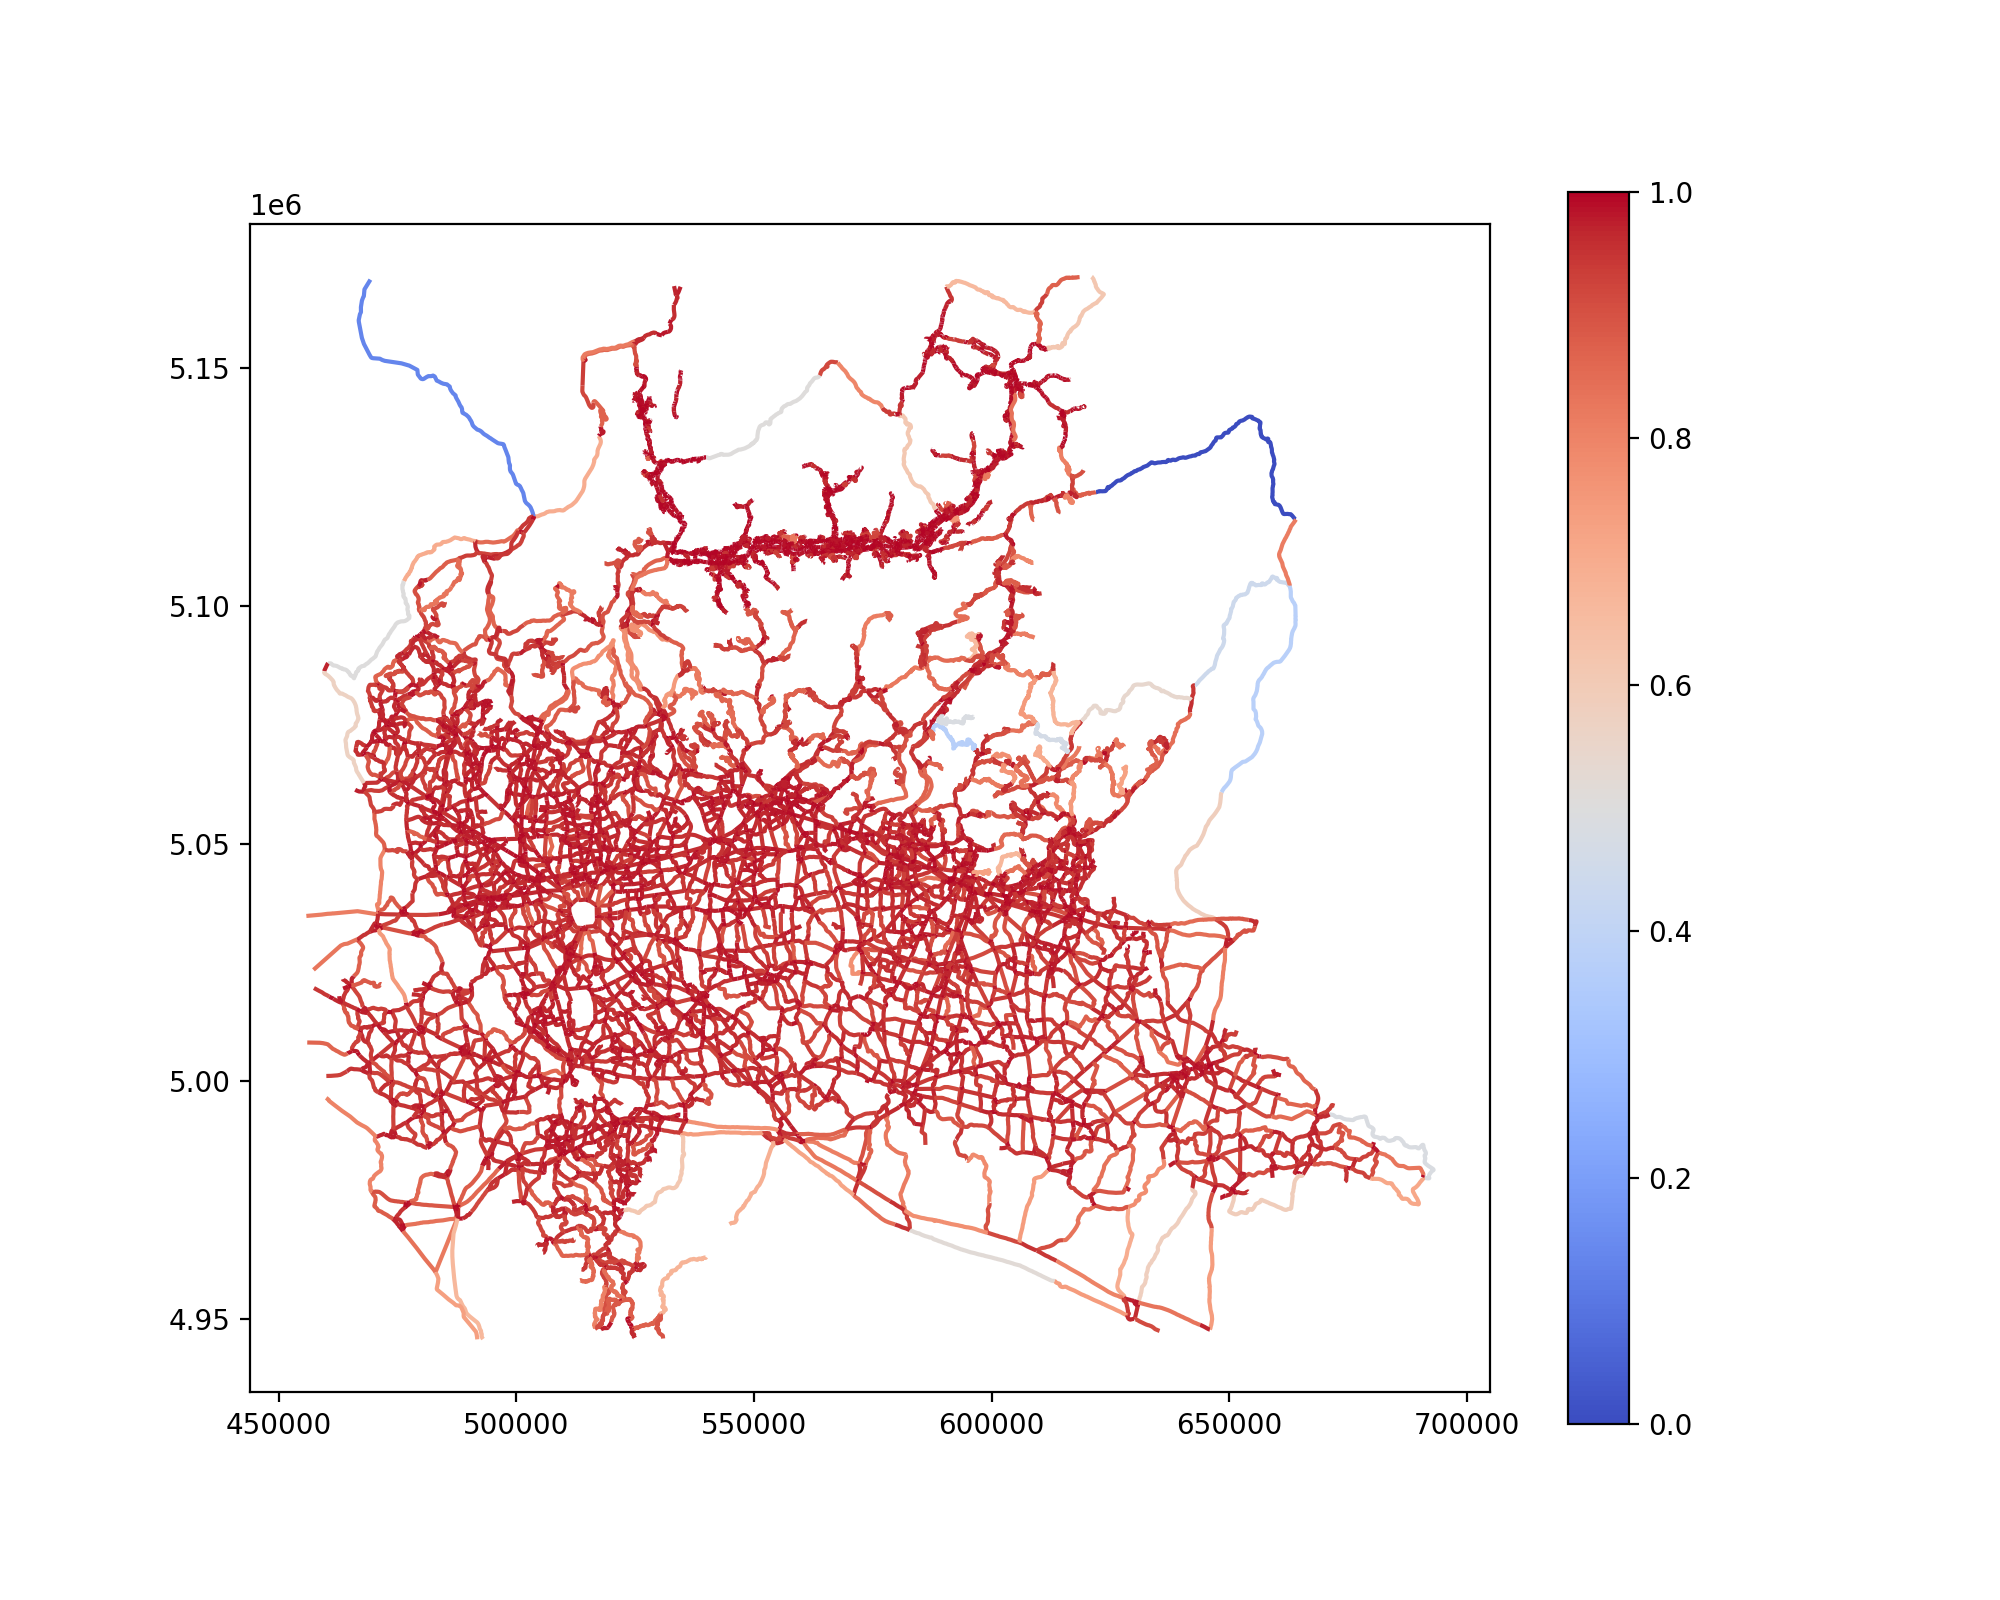

In [7]:
fig  = plt.figure(figsize = (10,8))
ax = fig.gca()
DF_Lombardia.plot(column = "weight_0", cmap = "coolwarm", ax  = ax )
sm = plt.cm.ScalarMappable(cmap= "coolwarm", norm=plt.Normalize(vmin = 0, vmax=1))
plt.colorbar(sm)
plt.show()

### Weighted Road Network 


In [8]:
G = nx.from_pandas_edgelist(DF_Lombardia, source = "first_point", target = "last_point", edge_attr= "weight_0")

In [10]:
dict_x1 = pd.Series(DF_Lombardia.y1.values,index=DF_Lombardia.first_point.values).to_dict()
dict_y1 = pd.Series(DF_Lombardia.x1.values,index=DF_Lombardia.first_point.values).to_dict()

dict_x2 = pd.Series(DF_Lombardia.y2.values,index=DF_Lombardia.last_point.values).to_dict()
dict_y2 = pd.Series(DF_Lombardia.x2.values,index=DF_Lombardia.last_point.values).to_dict()

nx.set_node_attributes(G, dict_x1, "x")
nx.set_node_attributes(G, dict_y1, "y")

nx.set_node_attributes(G, dict_x2, "x")
nx.set_node_attributes(G, dict_y2, "y")

In [11]:
Relabeled_G = nx.convert_node_labels_to_integers(G)
Road_Net = Relabeled_G.to_undirected()

In [12]:
pos = mergeDict(nx.get_node_attributes(Road_Net, "x"), nx.get_node_attributes(Road_Net, "y"))
nx.set_node_attributes(Road_Net, pos, "pos")

In [13]:
# It takes a while - don't worry 
cmap = plt.get_cmap('coolwarm') 
cNorm  = colors.Normalize(vmin=0, vmax= 1.0)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
colorList = []

for i in range(len(Road_Net.edges)):
    colorVal = scalarMap.to_rgba(list(nx.get_edge_attributes(Road_Net,'weight_0').values())[i])
    colorList.append(colorVal)

<IPython.core.display.Javascript object>


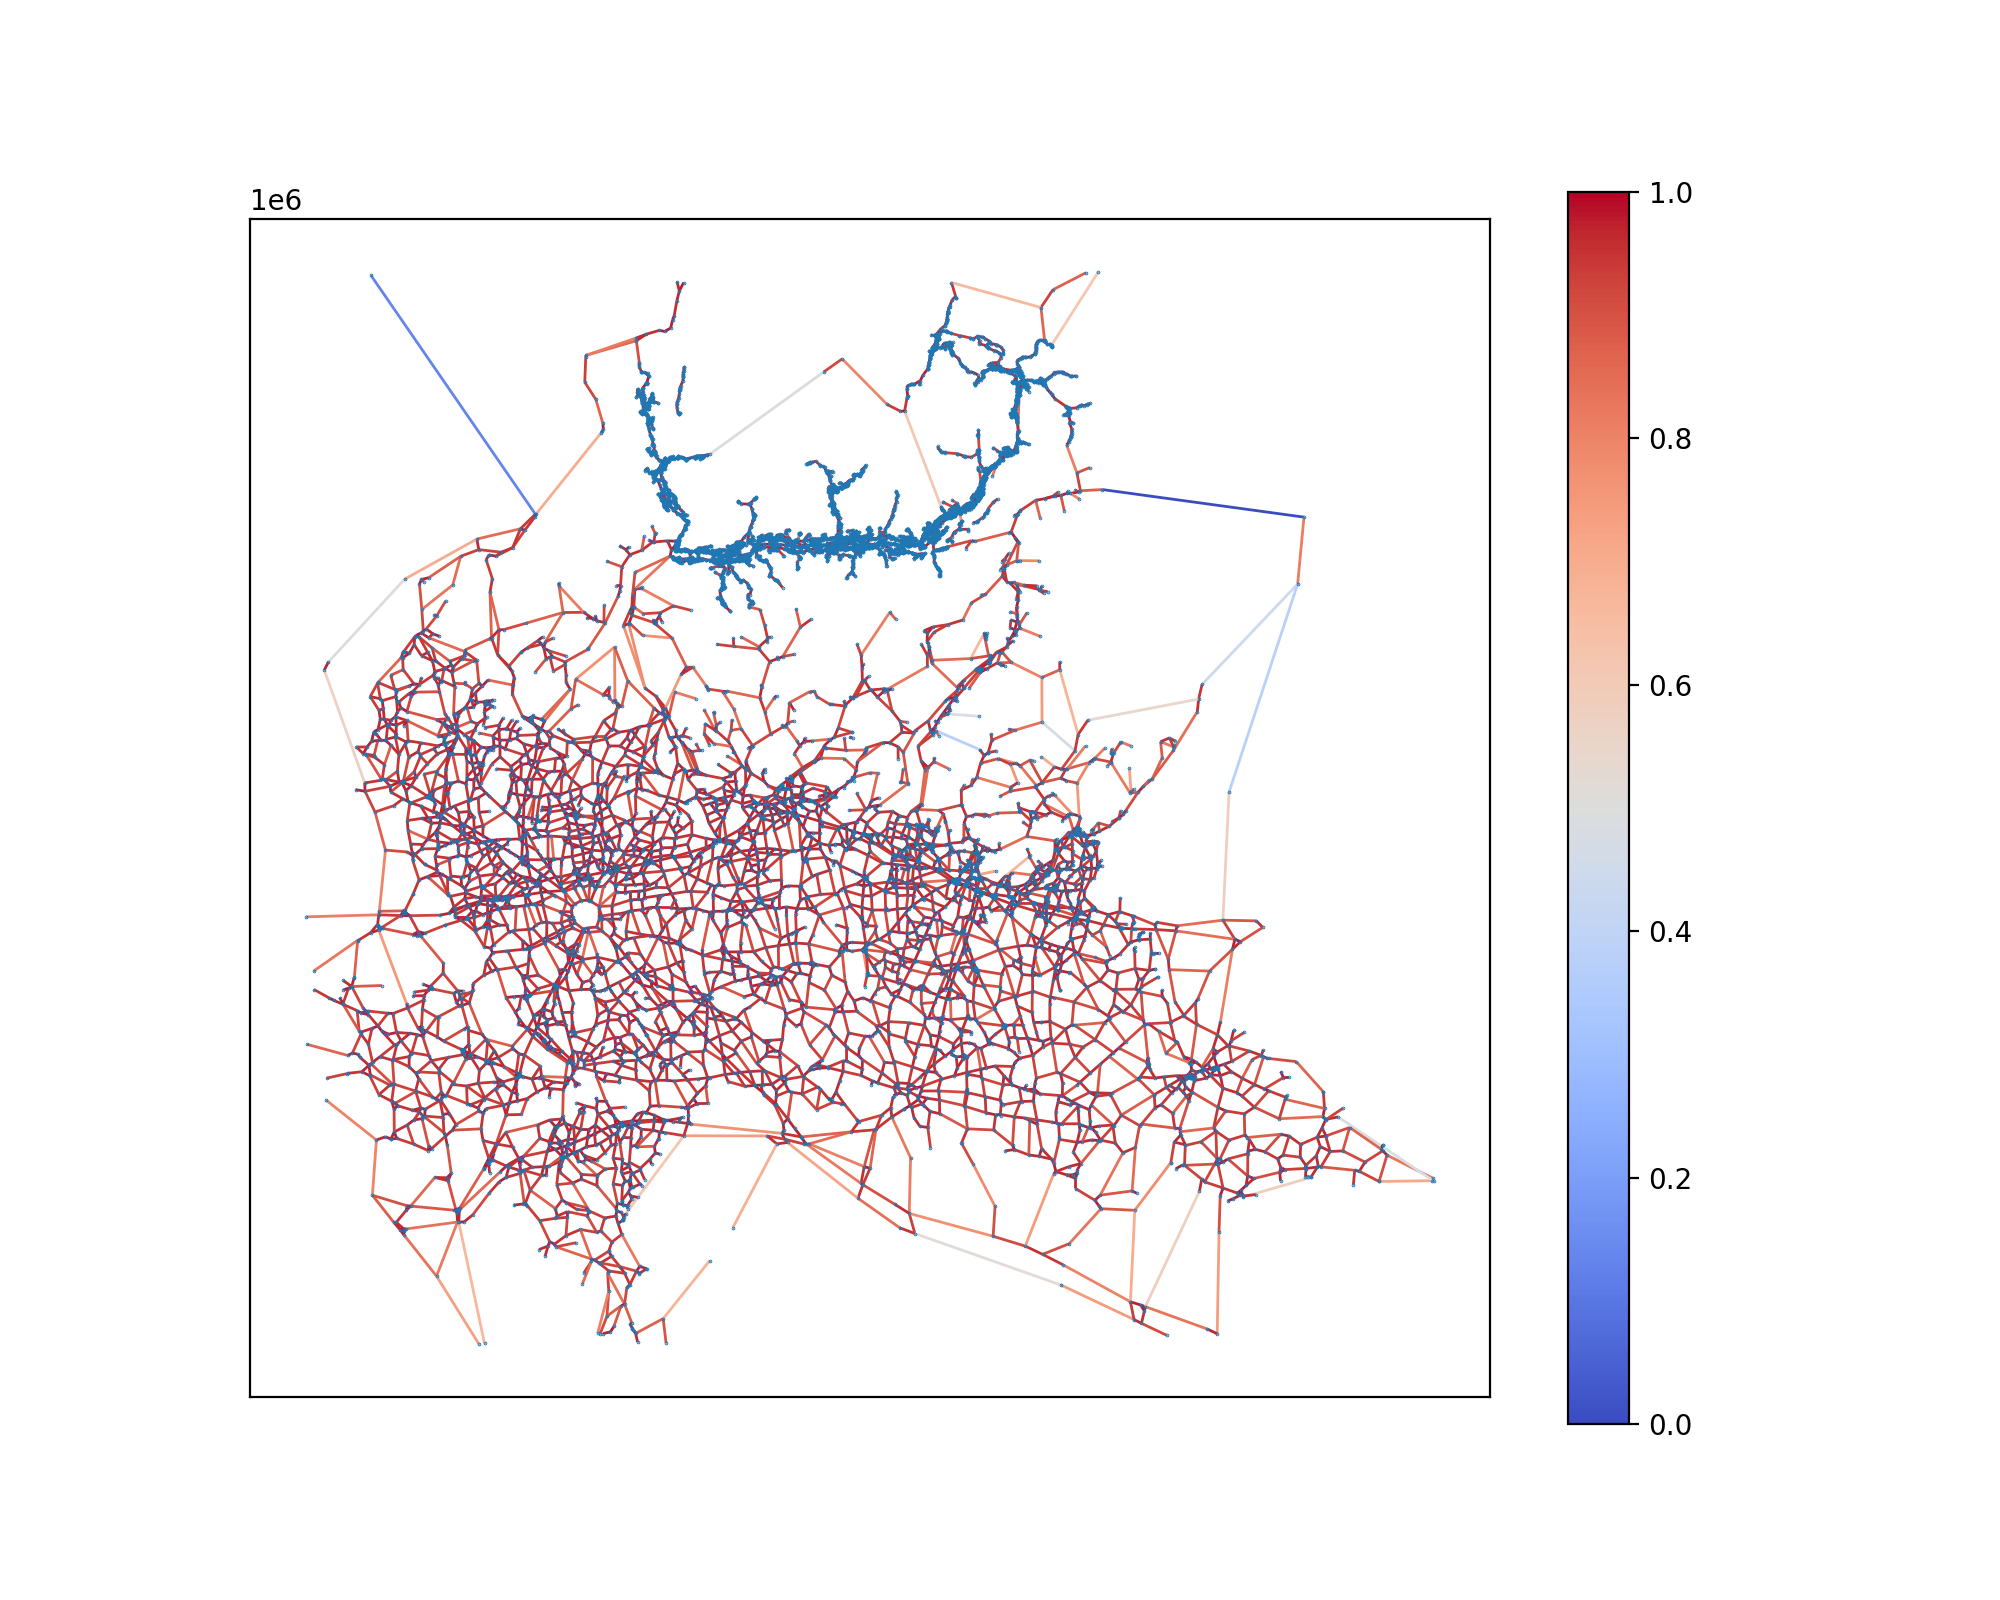

In [14]:
fig = plt.figure(figsize = (10,8))
ax = fig.gca()
nx.draw_networkx(Road_Net,pos = nx.get_node_attributes(Road_Net, "pos") , edge_color = colorList, node_size = 0.1, with_labels= False)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
ax.axis("scaled")
plt.colorbar(sm)
plt.show()

In [15]:
# Export to Gephi 
# nx.write_gexf(Road_Net, "Road_Lombardy.gexf")

## SIR Dynamics

<IPython.core.display.Javascript object>


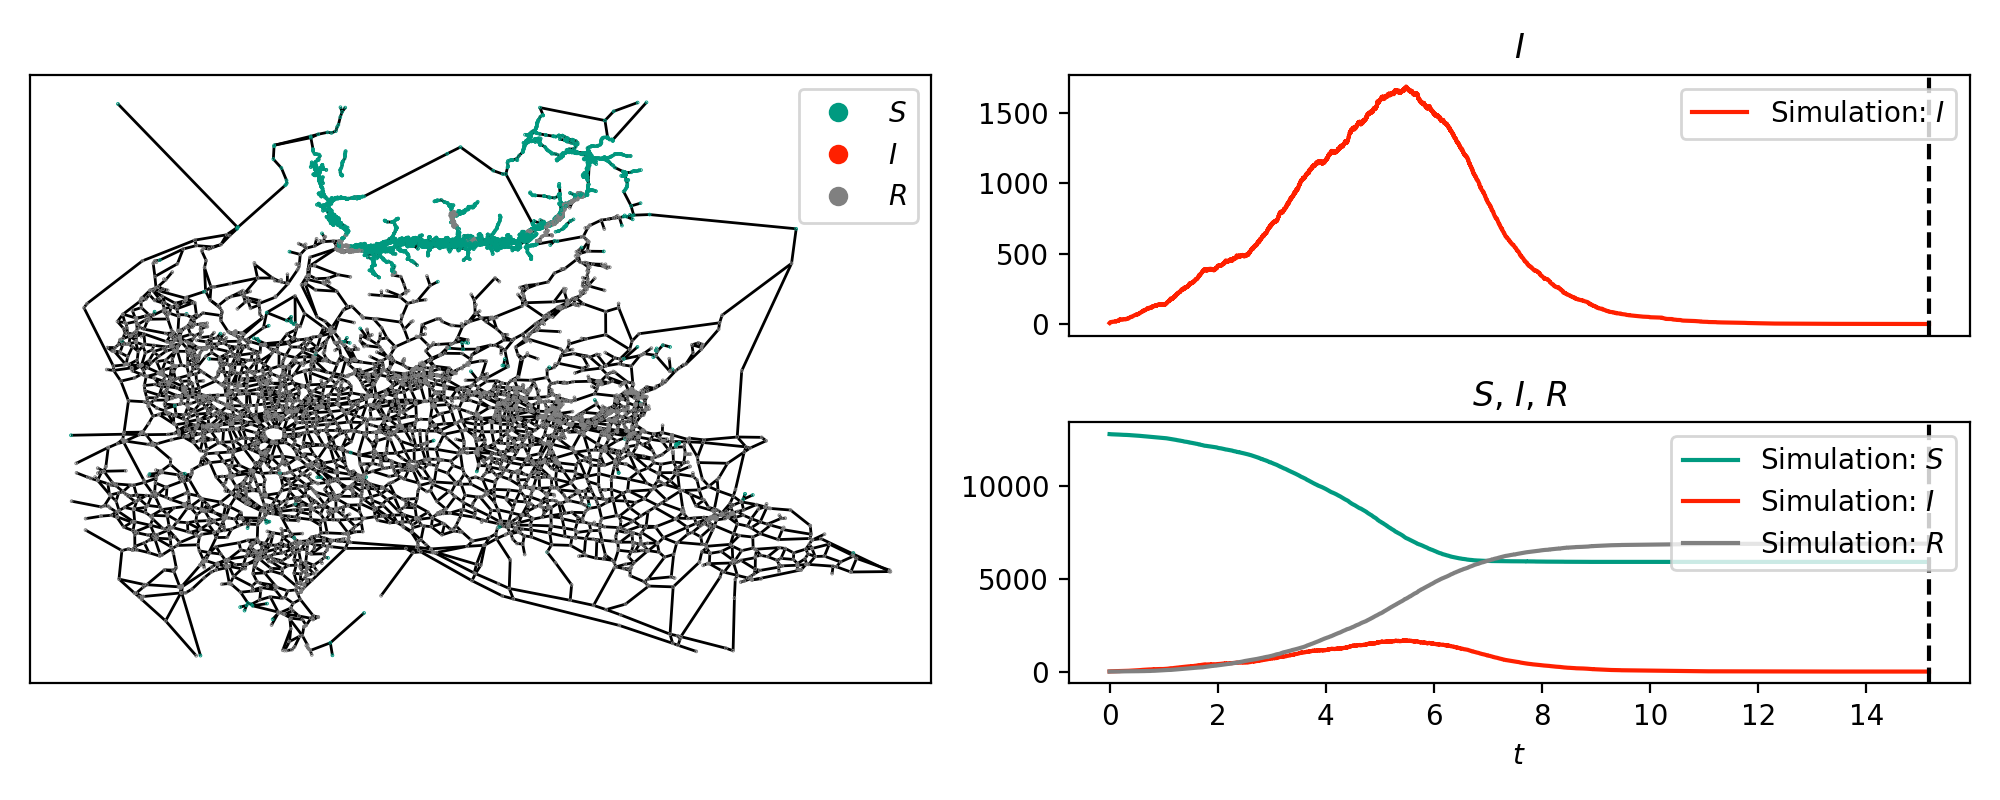

In [16]:
initial_infections = [11049, 20, 874, 10475, 9, 1, 574] # some random guessed nodes 

pos= nx.get_node_attributes(Road_Net, "pos")
sim_kwargs = {'pos': pos}


sim = EoN.fast_SIR(Road_Net, 8.35, 1.0, transmission_weight= "weight_0",  initial_infecteds =  initial_infections, 
               tmax = 40, return_full_data=True, sim_kwargs = sim_kwargs )

ani=sim.animate(ts_plots=['I', 'SIR'], node_size = 0.1)


In [17]:
# Uncomment to save the animation as .mp4 video
#ani.save('SIR_Covid_Lombardia.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

### Simulating Social Distancing Measures

In [18]:
from ipywidgets import interact, fixed

In [19]:
def social_dist_sim(network, social_dist_factor):
    
    initial_infections = [11049, 20, 874, 10475, 9, 1, 574]
    
    pos= nx.get_node_attributes(network, "pos")
    sim_kwargs = {'pos': pos}
    
    weight = {k: v / social_dist_factor for k, v in nx.get_edge_attributes(network, "weight_0").items()}
    nx.set_edge_attributes(network, weight, "weight")
    sim = EoN.fast_SIR(network, 8.35, 1.0, transmission_weight= "weight" ,  initial_infecteds =  initial_infections, 
               tmax = 40, return_full_data=True, sim_kwargs = sim_kwargs )
    ani=sim.animate(ts_plots=['I', 'SIR'], node_size = 0.1)
    

In [20]:
interact(social_dist_sim, network = fixed(Road_Net), social_dist_factor = (1.0, 5.0, 0.05))

interactive(children=(FloatSlider(value=3.0, description='social_dist_factor', max=5.0, min=1.0, step=0.05), O…

<function __main__.social_dist_sim(network, social_dist_factor)>